In [276]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
import os, fnmatch
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures 
import seaborn as sns
%matplotlib inline
from keras.layers import Input, Dense
from keras.models import Model
# from keras.op
from keras import optimizers
from keras import regularizers
from PIL import Image
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np

In [277]:
data = pd.read_csv("DFBS_Unique.csv");

In [278]:
data.head()

,Unnamed: 0,_Glon,_Glat,_RAJ2000,_DEJ2000,Cl,Name,Vmag,z,plate,dx,dy
0,0,deg,deg,deg,deg,NaN,NaN,mag,NaN,NaN,0,0
1,1,100.174423,-55.203358,0.04875,5.388056,Sy1,RXS J00001+0523,16.4,0.040,fbs0524_cor.fits.hdr,5424,857
2,2,99.844434,-57.30727,0.61,3.351667,Sy1,MARK 543,14.68,0.026,fbs1173_cor.fits.hdr,3982,5088
3,3,86.112841,-70.112882,0.88375,-10.744722,Sy1,NGC 7808,15.4,0.029,fbs0874_cor.fits.hdr,2871,555
4,4,114.304767,-16.638006,1.039583,45.440278,Sy1,RXS J00041+4526,16.9,0.120,fbs1036_cor.fits.hdr,3623,594


In [279]:
all_tiff_files = []
listOfFiles = os.listdir('./UClassificationDataCleaned/')
pattern = "*.tiff"
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            all_tiff_files.append('./UClassificationDataCleaned/'+entry)

In [280]:
len(all_tiff_files)

2951

In [281]:
new_index = 0
arr_data = []
for index, row in data.iterrows():
    if index == 0: continue
    glon = row["_Glon"]
    glat = row["_Glat"]
    raj = row["_RAJ2000"]
    dej = row["_DEJ2000"]
    cl = row["Cl"]
    name = row["Name"]
    vmag = row["Vmag"]
    z = row["z"]
    plate = row["plate"]
    dx = row["dx"]
    dy = row["dy"]
    if cl == "C" or cl == "PN" or cl == "cv" : 
        continue
        
    for i in range(len(all_tiff_files)):
        file_name = (all_tiff_files[i].split("/")[2]).split(".tiff")[0];
        if name == file_name:
            arr_obj = []
            arr_obj.append(name)
            arr_obj.append(cl)
            arr_obj.append(all_tiff_files[i])
            arr_data.append(arr_obj)
            break
#
        

In [282]:
cl_data = pd.DataFrame(arr_data)

In [283]:
cl_data.head()

,0,1,2
0,RXS J00001+0523,Sy1,./UClassificationDataCleaned/RXS J00001+0523.tiff
1,MARK 543,Sy1,./UClassificationDataCleaned/MARK 543.tiff
2,NGC 7808,Sy1,./UClassificationDataCleaned/NGC 7808.tiff
3,MARK 335,Sy1,./UClassificationDataCleaned/MARK 335.tiff
4,MS 00071-0231,Sy1,./UClassificationDataCleaned/MS 00071-0231.tiff


In [284]:
cl_data[1].value_counts()

sd     989
Mrk    526
M      452
WD     309
Sy1    304
QSO    273
Name: 1, dtype: int64

In [285]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [286]:
le.fit(cl_data[1])
cl_data[1]=le.transform(cl_data[1])

In [287]:
cl_data.head()

,0,1,2
0,RXS J00001+0523,3,./UClassificationDataCleaned/RXS J00001+0523.tiff
1,MARK 543,3,./UClassificationDataCleaned/MARK 543.tiff
2,NGC 7808,3,./UClassificationDataCleaned/NGC 7808.tiff
3,MARK 335,3,./UClassificationDataCleaned/MARK 335.tiff
4,MS 00071-0231,3,./UClassificationDataCleaned/MS 00071-0231.tiff


In [288]:
cl_data[1].value_counts()

5    989
1    526
0    452
4    309
3    304
2    273
Name: 1, dtype: int64

In [289]:
X = cl_data.iloc[:, 2]
Y = cl_data.iloc[:, 1]

In [290]:
X = X.values
Y = Y.values

In [291]:
images_list = []
max_width = 0
max_height = 0
ind = 0
for i in range(len(X)):
    im = Image.open(X[i])
    arr = np.array(im)#.flatten()
    
    arr=(arr-arr.min())/(arr.max()-arr.min())
    #arr = arr / 0xffff
    s = arr.shape
    if s[0] > max_height:
        max_height = s[0]
    if s[1] > max_width:
        max_width = s[1]
        ind = i
    images_list.append(arr)

In [292]:
print(max_width, max_height)

20 140


In [293]:
for i in range(len(images_list)):
    s = images_list[i].shape
    d_width = (max_width - s[1])
    d_height = (max_height - s[0])
    
    d_top = int(d_height / 2)
    d_bottom = int(d_height - d_top)
    
    d_left = int(d_width / 2)
    d_right = int(d_width - d_left)
    #print(d_top, d_bottom, d_left, d_right)
    
    arr = images_list[i]
    for l in range(d_left):
        arr = np.insert(arr, 0, 0, axis = 1)
    
    for r in range(d_right):
        b = np.zeros((s[0],1))
        arr = np.append(arr, b, axis = 1)
    
    for t in range(d_top):
        arr = np.insert(arr, 0, 0, axis = 0)
    
    for b in range(d_bottom):
        b = np.zeros((1, arr.shape[1],))
        arr = np.append(arr, b, axis = 0)
    
    images_list[i] = arr#.flatten()

20 140


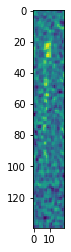

In [294]:
width = max_width
height = max_height
print(width, height)
plt.imshow(images_list[12])

In [295]:
from tensorflow.python.client import device_lib
import tensorflow as tf
import keras
print(device_lib.list_local_devices())

config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3219887759534250492
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1441641267
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10034078363121410156
physical_device_desc: "device: 0, name: GeForce GTX 750 Ti, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [299]:
images_np = np.array(images_list)
file_names_np = np.array(all_tiff_files)

In [300]:
X_train, X_test, Y_train, Y_test = train_test_split(images_np, Y, test_size=0.2, random_state=100, stratify=Y)
Y_train = keras.utils.to_categorical(Y_train, 6)
Y_test = keras.utils.to_categorical(Y_test, 6)

In [301]:
X_train = X_train.reshape(X_train.shape[0], 140, 20, 1)
X_test = X_test.reshape(X_test.shape[0], 140, 20, 1)
input_shape = (140, 20, 1)

In [302]:
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (2282, 140, 20, 1)
2282 train samples
571 test samples


In [404]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

model = Sequential()
model.add(Conv2D(128, kernel_size=(3,3), input_shape=input_shape, padding="same"))
model.add(MaxPooling2D(pool_size=(3, 1)))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 1)))

model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 4)))

model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.5))
model.add(Dense(6,activation=tf.nn.softmax))

In [ ]:
#model.compile(optimizer='adam', 
#              loss='sparse_categorical_crossentropy', 
#              metrics=['accuracy'])
#model.fit(x=x_train,y=y_train, epochs=10)

In [221]:
from keras.regularizers import l2
from keras.regularizers import l1
from keras.layers import Dropout
inpu_dim = X_train.shape[1]
h_1 = 2048
h_2 = 1024
h_3 = 512
out_shape = 6

input_vect = Input(shape = (inpu_dim,))
x = BatchNormalization()(input_vect)
x = Dropout(0.5)(x)
x = Dense(h_1, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(h_2, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(h_3, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
encoded = Dense(out_shape, activation='softmax')(x)

encoder = Model(input_vect, encoded)

In [405]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 140, 20, 128)      1280      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 46, 20, 128)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 46, 20, 64)        73792     
_________________________________________________________________
activation_9 (Activation)    (None, 46, 20, 64)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 15, 20, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 15, 20, 32)        18464     
_________________________________________________________________
activation_10 (Activation)   (None, 15, 20, 32)        0         
__________

In [406]:
#image data generator keras
cw = {0:1, 1:1, 2:4, 3:1, 4:4, 5:1}
adadelta = optimizers.Adadelta(lr=0.1, rho=0.95)
model.compile(optimizer=adadelta , loss='binary_crossentropy', metrics=['accuracy'])

In [407]:
history = model.fit(X_train, Y_train, epochs = 100, batch_size = 64, shuffle=True, validation_data=(X_test, Y_test), class_weight=cw)

Train on 2282 samples, validate on 571 samples
Epoch 1/100
2282/2282 [==============================] - 5s 2ms/step - loss: 0.7180 - acc: 0.8333 - val_loss: 0.4533 - val_acc: 0.8333
Epoch 2/100
2282/2282 [==============================] - 2s 884us/step - loss: 0.6961 - acc: 0.8333 - val_loss: 0.4582 - val_acc: 0.8333
Epoch 3/100
2282/2282 [==============================] - 2s 900us/step - loss: 0.6860 - acc: 0.8330 - val_loss: 0.4474 - val_acc: 0.8333
Epoch 4/100
2282/2282 [==============================] - 2s 909us/step - loss: 0.6783 - acc: 0.8333 - val_loss: 0.4478 - val_acc: 0.8333
Epoch 5/100
2282/2282 [==============================] - 2s 906us/step - loss: 0.6692 - acc: 0.8328 - val_loss: 0.4432 - val_acc: 0.8330
Epoch 6/100
2282/2282 [==============================] - 2s 905us/step - loss: 0.6592 - acc: 0.8338 - val_loss: 0.4225 - val_acc: 0.8342
Epoch 7/100
2282/2282 [==============================] - 2s 903us/step - loss: 0.6461 - acc: 0.8382 - val_loss: 0.4073 - val_acc: 0.8

2282/2282 [==============================] - 2s 910us/step - loss: 0.5029 - acc: 0.8608 - val_loss: 0.3093 - val_acc: 0.8722
Epoch 61/100
2282/2282 [==============================] - 2s 908us/step - loss: 0.5073 - acc: 0.8639 - val_loss: 0.3180 - val_acc: 0.8695
Epoch 62/100
2282/2282 [==============================] - 2s 921us/step - loss: 0.4946 - acc: 0.8654 - val_loss: 0.3102 - val_acc: 0.8692
Epoch 63/100
2282/2282 [==============================] - 2s 930us/step - loss: 0.5063 - acc: 0.8609 - val_loss: 0.3146 - val_acc: 0.8704
Epoch 64/100
2282/2282 [==============================] - 2s 912us/step - loss: 0.4961 - acc: 0.8655 - val_loss: 0.3163 - val_acc: 0.8678
Epoch 65/100
2282/2282 [==============================] - 2s 915us/step - loss: 0.5047 - acc: 0.8631 - val_loss: 0.3150 - val_acc: 0.8687
Epoch 66/100
2282/2282 [==============================] - 2s 918us/step - loss: 0.5006 - acc: 0.8631 - val_loss: 0.3241 - val_acc: 0.8616
Epoch 67/100
2282/2282 [=======================

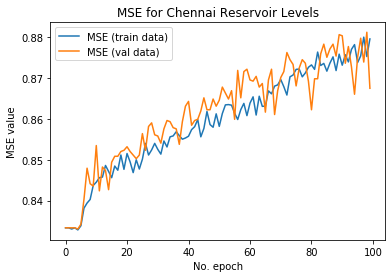

In [408]:
plt.plot(history.history['acc'], label='MSE (train data)')
plt.plot(history.history['val_acc'], label='MSE (val data)')
plt.title('MSE for Chennai Reservoir Levels')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [409]:
prediction = model.predict(X_test)

In [410]:
#Y_pred = keras.utils.to_categorical(Y, 9)
Y_test

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [411]:
for i in range(len(prediction)):
    prediction[i] = prediction[i] > 0.5

In [412]:
prediction

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [413]:
prediction.shape

(571, 6)

In [414]:
Y_test.shape

(571, 6)

In [415]:
c = 0
for i in range(len(Y_test)):
    if(np.array_equal(Y_test[i], prediction[i])):
        c = c + 1
        

In [416]:
print(c)

243


In [417]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

print('Accuracy:', accuracy_score(Y_test, prediction))
print ('F1 score:', f1_score(Y_test, prediction, average = "weighted"))
print ('Recall:', recall_score(Y_test, prediction, average = "weighted"))
print ('Precision:', precision_score(Y_test, prediction, average = "weighted"))
print ('\n clasification report:\n', classification_report(Y_test,prediction))
print ('\n confussion matrix:\n',confusion_matrix(Y_test, prediction))

Accuracy: 0.425569176882662
F1 score: 0.5137289726558679
Recall: 0.425569176882662
Precision: 0.7447473820539534

 clasification report:
               precision    recall  f1-score   support

           0       0.88      0.66      0.75        90
           1       0.77      0.35      0.48       105
           2       0.27      0.42      0.33        55
           3       0.80      0.07      0.12        61
           4       0.40      0.35      0.38        62
           5       0.89      0.49      0.64       198

   micro avg       0.66      0.43      0.52       571
   macro avg       0.67      0.39      0.45       571
weighted avg       0.74      0.43      0.51       571
 samples avg       0.43      0.43      0.43       571



C:\Users\Ghevond\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


ValueError: multilabel-indicator is not supported

In [342]:
prediction

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)